In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Read dataset from csv file**

In [ ]:
# Read dataset from csv
import pandas as pd
import os
import numpy as np
import time

train_dir = '/content/drive/MyDrive/CapstoneDataset/training'
test_dir = '/content/drive/MyDrive/CapstoneDataset/test'

train_data = []
test_data = []
file_number = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18']

for number in file_number:
  print(train_dir+'/'+number+'_train.csv')
  df = pd.read_csv(train_dir+'/'+number+'_train.csv',header=5)
  df = df.drop('Frame', axis=1)
  df = df.drop('Time (Seconds)', axis=1)
  train_data.append(df)

for number in file_number:
  print(test_dir+'/'+number+'_test.csv')
  df = pd.read_csv(test_dir+'/'+number+'_test.csv',header=5)
  df = df.drop('Frame', axis=1)
  df = df.drop('Time (Seconds)', axis=1)
  test_data.append(df)

/content/drive/MyDrive/CapstoneDataset/training/01_train.csv
/content/drive/MyDrive/CapstoneDataset/training/02_train.csv
/content/drive/MyDrive/CapstoneDataset/training/03_train.csv
/content/drive/MyDrive/CapstoneDataset/training/04_train.csv
/content/drive/MyDrive/CapstoneDataset/training/05_train.csv
/content/drive/MyDrive/CapstoneDataset/training/06_train.csv
/content/drive/MyDrive/CapstoneDataset/training/07_train.csv
/content/drive/MyDrive/CapstoneDataset/training/08_train.csv
/content/drive/MyDrive/CapstoneDataset/training/09_train.csv
/content/drive/MyDrive/CapstoneDataset/training/10_train.csv
/content/drive/MyDrive/CapstoneDataset/training/11_train.csv
/content/drive/MyDrive/CapstoneDataset/training/12_train.csv
/content/drive/MyDrive/CapstoneDataset/training/13_train.csv
/content/drive/MyDrive/CapstoneDataset/training/14_train.csv
/content/drive/MyDrive/CapstoneDataset/training/15_train.csv
/content/drive/MyDrive/CapstoneDataset/training/16_train.csv
/content/drive/MyDrive/C

## **Use Furthest Point Sampling and export data to csv**
This part took me over one hour. I exported the final result to csv file. I won't run this part again.

In [ ]:
# Furthest Point Sampling
from os import remove
def read_points(x,y,z):
    points = np.stack([x, y, z], axis=1)
    return points

''' Strategy of FPS
Step 1: Use the first point in the point cloud as the query point and take the furthest point from the remaining points
Step 2: Continue with the point taken out as the query point and take the furthest point from the remaining points. 
Now, since the number of points already taken out is greater than 1, each point in the set of points already selected needs to be taken into account, 
The calculation logic is as follows.
    Step 2.1: For any of the remaining points, calculate the distance from that point to all points in the selected point set.
    Step 2.2: Take the minimum value, which is the distance from the remaining points to the selected set of points.
    Step 2.3: After calculating the distance of each remaining point to the point set, take the point with the maxiumn distance.
Step 3: repeat step 2 until the number K=100.
'''
class FPS:
    # eliminate duplicate points
    def __init__(self, points):
        print('init start')
        self.points = np.unique(points, axis=0)
        print('init finish')

    # calculate the distance from any of the remaining points to all points in the selected point set. np.stack()
    # Take the minumum distance as the the distance from the remaining points to the selected set of points. np.min()
    # After calculating the distance of each remaining point to the point set, take the point with the maxiumn distance. np.argmax()
    def get_min_distance(self, a, b):
        distance = []
        for i in range(a.shape[0]):
            dis = np.sum(np.square(a[i] - b), axis=-1)
            distance.append(dis)
        distance = np.stack(distance, axis=-1)
        distance = np.min(distance, axis=-1)
        return np.argmax(distance)
    
    # find minimun xyz value and maximum xyz value。
    # Arrange and combine all values to obtain the cornermost point set in the point cloud.
    @staticmethod
    def get_model_corners(model):
        min_x, max_x = np.min(model[:, 0]), np.max(model[:, 0])
        min_y, max_y = np.min(model[:, 1]), np.max(model[:, 1])
        min_z, max_z = np.min(model[:, 2]), np.max(model[:, 2])
        corners_3d = np.array([
            [min_x, min_y, min_z],
            [min_x, min_y, max_z],
            [min_x, max_y, min_z],
            [min_x, max_y, max_z],
            [max_x, min_y, min_z],
            [max_x, min_y, max_z],
            [max_x, max_y, min_z],
            [max_x, max_y, max_z],
        ])
        return corners_3d
    def compute_fps(self, K):
        # compute centre point location according to the cornermost point set
        corner_3d = self.get_model_corners(self.points)
        center_3d = (np.max(corner_3d, 0) + np.min(corner_3d, 0)) / 2
        A = np.array([center_3d])
        B = np.array(self.points)
        t = []
        # looking for k nodes
        for i in range(K):
            max_id = self.get_min_distance(A, B)
            A = np.append(A, np.array([B[max_id]]), 0)
            B = np.delete(B, max_id, 0)
            t.append(max_id)
        return A, t

# Calculate the center point of 89 markers. The result is a nrows*3 matrix.
def compute_center_point(dataframe):
  points = pd.DataFrame(data=None,columns=['X','Y','Z'])
  index = 0
  size = dataframe.shape[1]
  for row in dataframe.index:
    x = []
    y = []
    z = []
    for i in range(2,size+1,3):
      x.append(dataframe.loc[row][i-2])
      y.append(dataframe.loc[row][i-1])
      z.append(dataframe.loc[row][i])
    points.loc[index] = [sum(x)/len(x),sum(y)/len(y),sum(z)/len(z)]
    index = index + 1
  return points

# Export sampled data to csv
sampled_train_dir = '/content/drive/MyDrive/CapstoneDataset/sampled_training'
sampled_test_dir = '/content/drive/MyDrive/CapstoneDataset/sampled_test'


# First step, calculate the center point of 89 markers in each frame.
# Second step, use FPS to find the 100 furthest points and index.
# Third step, back to the original dataset to find corresponding 89 markers. 89*100 matrix.
count = 1
for df in train_data:
  points = compute_center_point(df)
  print(count)
  f = FPS(read_points(points['X'],points['Y'],points['Z']))

  # Get the index of the 100 furthest points
  # Change the sampling number here
  (C,index) = f.compute_fps(100)

  # create a new dataframe has the same column as old df
  # return to original point cloud and get 89 points according to index. The result is a 100*89 matrix.
  data1 = pd.DataFrame(columns = df.columns.to_list())
  for i in index:
    data1 = data1.append(df.loc[i],ignore_index=True)
  data1.to_csv(sampled_train_dir+'/'+str(count)+'.csv', index=False)
  print('finish output')
  count = int(count) + 1

count = 1
for df in test_data:
  points = compute_center_point(df)
  print(count)
  f = FPS(read_points(points['X'],points['Y'],points['Z']))

  # Change the sampling number here
  (C,index) = f.compute_fps(100)

  # create a new dataframe has the same column as old df and export it to csv
  data1 = pd.DataFrame(columns = df.columns.to_list())
  for i in index:
    data1 = data1.append(df.loc[i],ignore_index=True)
  data1.to_csv(sampled_test_dir+'/'+str(count)+'.csv', index=False)
  print('finish output')
  count = int(count) + 1

# count = 1
# for i in range(2,268,3):
#   f = FPS(read_points(df[df.columns[i-2]],df[df.columns[i-1]],df[df.columns[i]]))
#   C = f.compute_fps(100)#Number of sampling points
#   file.writelines("marker"+str(count)+"\n")
#   count = count + 1
#   for j in C:
#     file.writelines(str(float(j[0]))+"\t"+str(float(j[1]))+"\t"+str(float(j[2]))+"\n")

11
init start
init finish
finish output


## **Read sampled data from csv**

In [2]:
# Read sampled data from csv
import pandas as pd
import os
import numpy as np

sampled_train_dir = '/content/drive/MyDrive/CapstoneDataset/sampled_training'
sampled_test_dir = '/content/drive/MyDrive/CapstoneDataset/sampled_test'
sampled_file_number = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18']
sampled_train_data = []
sampled_test_data = []
for number in sampled_file_number:
  if number != '14':
    print(sampled_train_dir+'/'+number+'.csv')
    df = pd.read_csv(sampled_train_dir+'/'+number+'.csv')
    sampled_train_data.append(df)

for number in sampled_file_number:
  if number != '14':
    print(sampled_test_dir+'/'+number+'.csv')
    df = pd.read_csv(sampled_test_dir+'/'+number+'.csv')
    sampled_test_data.append(df)

/content/drive/MyDrive/CapstoneDataset/sampled_training/1.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/2.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/3.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/4.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/5.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/6.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/7.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/8.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/9.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/10.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/11.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/12.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/13.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/15.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/16.csv
/content/drive/MyDrive/CapstoneDataset/sampled_training/17.csv
/

## **Normalization**
I use the point cloud normalization strategy. Export data to csv.

In [ ]:
sampled_test_data[0]

,X,Y,Z,X.1,Y.1,Z.1,X.2,Y.2,Z.2,X.3,...,Z.85,X.86,Y.86,Z.86,X.87,Y.87,Z.87,X.88,Y.88,Z.88
0,0.434963,0.422864,0.116870,0.411616,0.397577,0.159184,0.379768,0.393446,0.197402,0.372607,...,0.277063,0.596774,-0.007099,0.208347,0.583374,-0.009286,0.156665,0.532232,-0.019313,0.096958
1,0.434507,0.432018,0.093004,0.413885,0.407089,0.136777,0.383881,0.403446,0.176707,0.379308,...,0.253253,0.595161,0.005245,0.185066,0.580828,0.001597,0.134623,0.528581,-0.007302,0.076955
2,0.493815,0.443950,0.154903,0.465639,0.413508,0.184705,0.438761,0.403676,0.220923,0.431270,...,0.276280,0.617295,-0.020251,0.206213,0.603368,-0.020923,0.154475,0.550394,-0.026201,0.096102
3,0.435764,0.517374,0.132633,0.422962,0.482907,0.166779,0.394214,0.473095,0.208975,0.386691,...,0.279238,0.591671,0.035793,0.206894,0.574161,0.038644,0.157503,0.523476,0.040360,0.104495
4,0.492502,0.437814,0.149007,0.465475,0.409884,0.182304,0.437079,0.402744,0.218669,0.430529,...,0.276129,0.617894,-0.020168,0.206546,0.603858,-0.020445,0.154959,0.551240,-0.023945,0.096700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.436846,0.424890,0.118869,0.413165,0.399692,0.160895,0.381339,0.395719,0.199160,0.374085,...,0.274901,0.597684,-0.006715,0.206616,0.583696,-0.008364,0.155496,0.532854,-0.015346,0.096443
96,0.432949,0.438816,0.112555,0.413109,0.412364,0.155371,0.382742,0.407904,0.194889,0.379224,...,0.253861,0.592682,0.006932,0.186160,0.577283,0.004213,0.136654,0.524823,-0.001618,0.079986
97,0.438386,0.517686,0.130052,0.428966,0.482877,0.164566,0.399824,0.474934,0.207663,0.390653,...,0.274011,0.591589,0.029590,0.201508,0.572973,0.032693,0.152909,0.522235,0.034887,0.100828
98,0.430501,0.427902,0.117854,0.407836,0.402124,0.159871,0.377291,0.397648,0.199049,0.370745,...,0.275360,0.591589,-0.004274,0.205324,0.577089,-0.005444,0.153940,0.523741,-0.010480,0.096438


In [ ]:
# Normalization
from itertools import chain

# Compute the center point of 89*100 points.
def compute_centroid(pc):
  centroid = []
  x = pd.DataFrame()
  y = pd.DataFrame()
  z = pd.DataFrame()
  for i in range(0,265,3):
    newX = pd.DataFrame(pc.iloc[:,i].values)
    x = x.append(newX,ignore_index=True)
  centroid.append(x.sum()/len(x))
  for j in range(1,266,3):
    newY = pd.DataFrame(pc.iloc[:,j].values)
    y = y.append(newY,ignore_index=True)
  centroid.append(y.sum()/len(y))
  for k in range(2,267,3):
    newZ = pd.DataFrame(pc.iloc[:,k].values)
    z = z.append(newZ,ignore_index=True)
  centroid.append(z.sum()/len(z))
  centroid = pd.DataFrame(centroid)
  return centroid

# centroid = compute_centroid(sampled_train_data[0])

def normalize_point_cloud(pc):
    centroid = compute_centroid(pc) # compute center of point cloud
    centroid = centroid.T
    centroid = centroid.values
    centroid = list(chain.from_iterable(centroid))
    # put centre of the point cloud to (0, 0, 0)
    for i in range(0,265,3):
      pc.iloc[:,i] = pc.iloc[:,i] - centroid[0]
    for j in range(1,266,3):
      pc.iloc[:,j] = pc.iloc[:,j] - centroid[1]
    for k in range(2,267,3):
      pc.iloc[:,k] = pc.iloc[:,k] - centroid[2]
    
    # find the longest axis in XYZ axis and compute the length. This step can get a scaling ratio.
    # Step 1: The point cloud after translation is squared
    # Step 2: Sum according to row. This step can get a 100*1 matrix. The original matrix is 100*267
    # Step 3: Find the square root and find the maxiumn value as scaling ratio
    m = np.max(np.sqrt(np.sum(pc ** 2, axis=1)))

    # Scaling point cloud according the ratio
    pc_normalized = pc / m # normalize point cloud to (-1,1) according to long axis
    return pc, pc_normalized, centroid, m  # centroid: center point, m: length of long axis, centroid and m can be used to compute keypoints


# Export normalization data to csv
normalize_train_dir = '/content/drive/MyDrive/CapstoneDataset/normalize_training'
normalize_test_dir = '/content/drive/MyDrive/CapstoneDataset/normalize_test'

count = 1
for data in sampled_train_data:
  print(count)
  (pc, pc_normalized, centroid, length) = normalize_point_cloud(data)
  if(pc_normalized.min().min() >= -1 and pc_normalized.max().max() <= 1):
    pc_normalized.to_csv(normalize_train_dir+'/'+str(count)+'.csv', index=False)
    print('finish output')
    count = int(count) + 1

count = 1
for data in sampled_test_data:
  print(count)
  (pc, pc_normalized, centroid, length) = normalize_point_cloud(data)
  if(pc_normalized.min().min() >= -1 and pc_normalized.max().max() <= 1):
    pc_normalized.to_csv(normalize_test_dir+'/'+str(count)+'.csv', index=False)
    print('finish output')
    count = int(count) + 1

1
finish output
2
finish output
3
finish output
4
finish output
5
finish output
6
finish output
7
finish output
8
finish output
9
finish output
10
finish output
11
finish output
12
finish output
13
finish output
14
finish output
15
finish output
16
finish output
17
finish output
18
finish output
1
finish output
2
finish output
3
finish output
4
finish output
5
finish output
6
finish output
7
finish output
8
finish output
9
finish output
10
finish output
11
finish output
12
finish output
13
finish output
14
finish output
15
finish output
16
finish output
17
finish output
18
finish output


## **Read normalization data from csv**

In [ ]:
# Read normalization data from csv
import pandas as pd
import os
import numpy as np

normalize_train_dir = '/content/drive/MyDrive/CapstoneDataset/normalize_training'
normalize_test_dir = '/content/drive/MyDrive/CapstoneDataset/normalize_test'
normalize_file_number = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18']
normalize_train_data = []
normalize_test_data = []
for number in normalize_file_number:
  print(normalize_train_dir+'/'+number+'.csv')
  df = pd.read_csv(normalize_train_dir+'/'+number+'.csv')
  normalize_train_data.append(df)

for number in normalize_file_number:
  print(normalize_test_dir+'/'+number+'.csv')
  df = pd.read_csv(normalize_test_dir+'/'+number+'.csv')
  normalize_test_data.append(df)

/content/drive/MyDrive/CapstoneDataset/normalize_training/1.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/2.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/3.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/4.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/5.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/6.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/7.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/8.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/9.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/10.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/11.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/12.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/13.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/14.csv
/content/drive/MyDrive/CapstoneDataset/normalize_training/15.csv
/content/drive/MyDrive/CapstoneDat

## **BP Neural Network**
https://blog.csdn.net/zhazhaqiangdedad/article/details/124920479?spm=1001.2014.3001.5501

https://blog.csdn.net/weixin_41477928/article/details/123337949

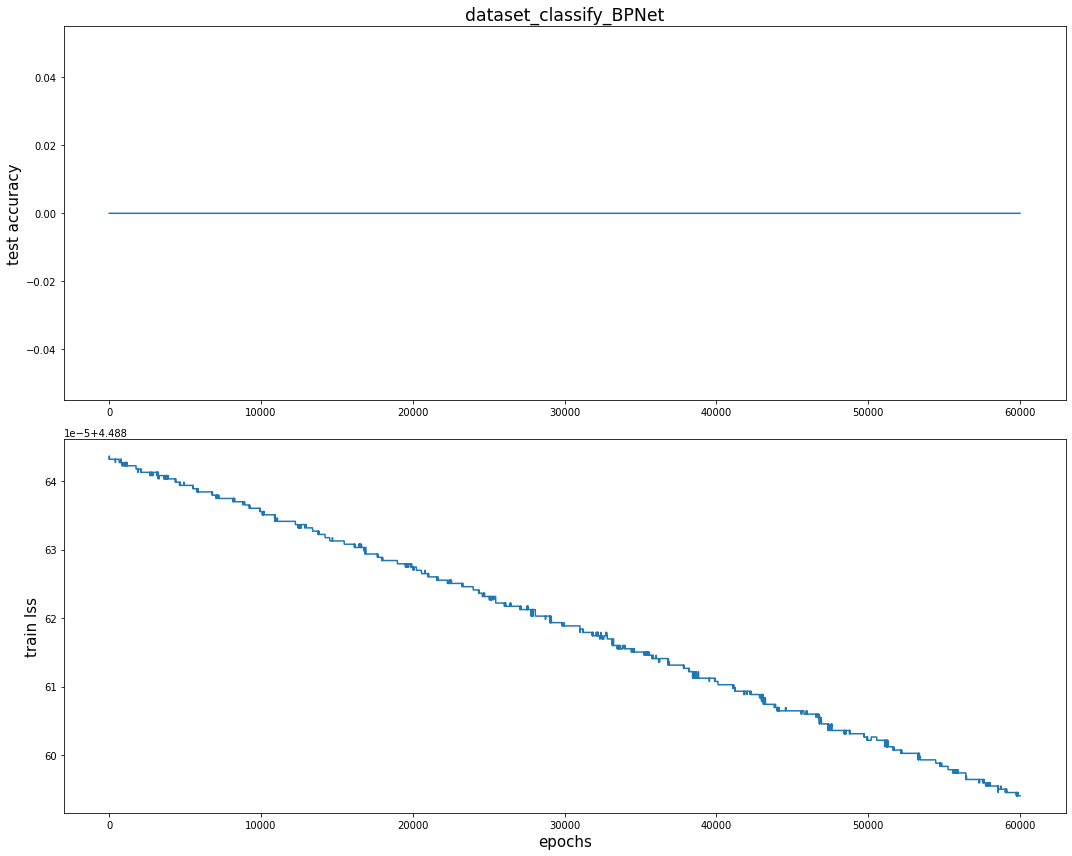

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split #training and test set split function
import torch
import torch.nn.functional as Fun

lr        = 0.00001 # learning rate
epochs    = 60000  # training round number 
n_feature = 3    # input node (x,y,z)
n_hidden  = 20   # hidden layer
n_output  = 89   # output node (89 classes)


# def data_gen(data):
#   newData = np.zeros((89,100,3))
#   index = 0
#   for i in range(0,265,3):
#     newData[index] = data.iloc[:,[i,i+1,i+2]].values
#     index = index + 1    
#   return newData

# def label_gen():
#   combined_labels = np.zeros((89,100,89))
#   for i in range(89):
#     for j in range(100):
#       combined_labels[i][j][i]=1
#   return combined_labels

# sampled_train_data[13] and sampled_test_data[13] has problem, so abondon it.
# put all data into 3 columns, 100*17*89=151300. This is training set
def data_gen(data):
  newData = np.zeros((151300,3))
  index = 0
  for i in range(0,265,3):
    for j in range(1700):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

# put sampled_train_data[0] data into 3 columns. This is test set.
def data_gen2(data):
  newData = np.zeros((8900,3))
  index = 0
  for i in range(0,265,3):
    for j in range(100):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

# create labels for all data. This is labels for training set
def label_gen():
  # labels = np.zeros(151300)
  combined_labels = np.array([0]*1700)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*1700)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

# create labels for sampled_test_data[0] data. This is labels for test set
def label_gen2():
  # labels = np.zeros(8900)
  combined_labels = np.array([0]*100)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*100)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

df_train = sampled_train_data[0]
for i in range(1,17):
  df_train = pd.concat([df_train,sampled_train_data[i]],axis=0)
x_train = data_gen(df_train)
y_train = label_gen()
x_test = data_gen2(sampled_test_data[0])
y_test = label_gen2()

# x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.2,random_state=22)

# normalization here
min_max_scaler = preprocessing.MinMaxScaler()
x_train = min_max_scaler.fit_transform(x_train)
x_test = min_max_scaler.fit_transform(x_test)

# change data to tensor
x_train=torch.FloatTensor(x_train)
y_train=torch.LongTensor(y_train)
x_test=torch.FloatTensor(x_test)
y_test=torch.LongTensor(y_test)

#2.create BP Neural Network
class BPNetModel(torch.nn.Module):
    def __init__(self,n_feature,n_hidden,n_output):
        super(BPNetModel, self).__init__()
        self.hiddden= torch.nn.Linear(n_feature,n_hidden)#define hidden layer
        self.out=torch.nn.Linear(n_hidden,n_output)#define output layer
    def forward(self,x):
        x=Fun.relu(self.hiddden(x)) #hidden layer activation function use relu() function
        out=Fun.softmax(self.out(x),dim=1) #output layer use softmax() function
        return out
#3.Define the optimizer and loss function
net=BPNetModel(n_feature=n_feature,n_hidden=n_hidden,n_output=n_output) #Call the network
optimizer=torch.optim.Adam(net.parameters(),lr=lr,eps=1e-3) #Use the Adam Optimizer and set the learning rate
loss_fun=torch.nn.CrossEntropyLoss() #The cross entropy loss function is generally used for multi-classification

#4.train data
loss_steps=np.zeros(epochs) #an array([ 0., 0., 0., 0., 0.]) contains 0, number is epochs
accuracy_steps=np.zeros(epochs)

for epoch in range(epochs):
    y_pred=net(x_train) #Forward propagation
    loss=loss_fun(y_pred,y_train)#Comparison of predicted and real values
    optimizer.zero_grad() #Gradient reset to 0
    loss.backward() #Back propagation
    optimizer.step() #Update gradient
    loss_steps[epoch]=loss.item()# store loss
    running_loss = loss.item()
    # print(f"{epoch} training，loss={running_loss}".format(epoch,running_loss))
    with torch.no_grad(): #Below is the calculation of no gradients, mainly used by the test set, no need to calculate gradients anymore
        y_test_pred=net(x_test)
        correct=(torch.argmax(y_test_pred)==y_test).type(torch.FloatTensor)
        accuracy_steps[epoch]=correct.mean()
    # print("accuracy", accuracy_steps[epoch])

#5.Plot loss function and precision
fig_name="dataset_classify_BPNet"
fontsize=15
fig,(ax1,ax2)=plt.subplots(2,figsize=(15,12),sharex=False)
ax1.plot(accuracy_steps)
ax1.set_ylabel("test accuracy",fontsize=fontsize)
ax1.set_title(fig_name,fontsize="xx-large")
ax2.plot(loss_steps)
ax2.set_ylabel("train lss",fontsize=fontsize)
ax2.set_xlabel("epochs",fontsize=fontsize)
plt.tight_layout()
plt.show()

In [16]:
res = np.zeros(8900)
index = 0
for pred in y_test_pred:
  res[index] = np.argmax(pred)
  index = index + 1
res
  # pred = np.zeros(8900)
  # for i in range(8900):
  #   pred[i] = np.argmax(y_test_pred[i])
  # pred_label = np.zeros((8900,89))
  # index = 0
  # for label in pred:
  #   pred_label[index][int(label)] = 1
  #   index = index + 1

array([37., 37., 37., ..., 37., 37., 37.])

## **Xgboost**

In [12]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
import time

# These functions are same as above
def data_gen(data):
  newData = np.zeros((151300,3))
  index = 0
  for i in range(0,265,3):
    for j in range(1700):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

def data_gen2(data):
  newData = np.zeros((8900,3))
  index = 0
  for i in range(0,265,3):
    for j in range(100):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

def label_gen():
  # labels = np.zeros(151300)
  combined_labels = np.array([0]*1700)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*1700)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

def label_gen2():
  # labels = np.zeros(8900)
  combined_labels = np.array([0]*100)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*100)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

df_train = sampled_train_data[0]
for i in range(1,17):
  df_train = pd.concat([df_train,sampled_train_data[i]],axis=0)
x_train = data_gen(df_train)
y_train = label_gen()
x_test = data_gen2(sampled_test_data[0])
y_test = label_gen2()

In [29]:
# X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25, random_state=100)

xgb_train=xgb.DMatrix(x_train,label=y_train)
xgb_test=xgb.DMatrix(x_test,label=y_test)



# Set the model parameters

params={
    'eta': 0.00001,
    'max_depth': 12,
    'subsample': 0.5,
    'objective': 'multi:softmax',
    'nthread': -1,
    'silent': 1,
    'booster': 'gbtree',
    'num_class': 89
}

watchlist=[(xgb_train,'train'),(xgb_test,'test')]
# Set up training rounds. 1000 rounds here
num_round=100
bst=xgb.train(params,
              xgb_train,
              num_round,
              watchlist,
              verbose_eval=10, # display 10 batch per time
              early_stopping_rounds=100)

# prediction

pred=bst.predict(xgb_test)
# print(pred)

# evaluation

# error_rate=np.sum(pred!=test.lable)/test.lable.shape[0]
error_rate=np.sum(pred!=y_test)/y_test.shape[0]

# This is the error rate of test set
print('test set error rate(softmax):{}'.format(error_rate))

# this is the accuracy of the test set
accuray=1-error_rate
print('test set accuracy：%.4f' %accuray)

[0]	train-merror:0.223239	test-merror:0.403371
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 100 rounds.
[10]	train-merror:0.172022	test-merror:0.316517
[20]	train-merror:0.169736	test-merror:0.309888
[30]	train-merror:0.16959	test-merror:0.310112
[40]	train-merror:0.167964	test-merror:0.308427
[50]	train-merror:0.168215	test-merror:0.311348
[60]	train-merror:0.16764	test-merror:0.313371
[70]	train-merror:0.167118	test-merror:0.31382
[80]	train-merror:0.167488	test-merror:0.31382
[90]	train-merror:0.167462	test-merror:0.311798
[99]	train-merror:0.166332	test-merror:0.310562
测试集错误率(softmax):0.310561797752809
测试集准确率：0.6894


## **Supported Vector Machine**

In [3]:
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
import sklearn.svm as svm

# These functions are same as above
def data_gen(data):
  newData = np.zeros((151300,3))
  index = 0
  for i in range(0,265,3):
    for j in range(1700):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

def data_gen2(data):
  newData = np.zeros((8900,3))
  index = 0
  for i in range(0,265,3):
    for j in range(100):
      newData[index][0] = data.iloc[j,i]
      newData[index][1] = data.iloc[j,i+1]
      newData[index][2] = data.iloc[j,i+2]
      index = index + 1   
  return newData

def label_gen():
  # labels = np.zeros(151300)
  combined_labels = np.array([0]*1700)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*1700)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

def label_gen2():
  # labels = np.zeros(8900)
  combined_labels = np.array([0]*100)
  for i in range(1,89):
    combined_labels = np.append(combined_labels,[i]*100)
  # for i in range(len(labels)):
  #   labels[i][combined_labels[i]] = 1
  return combined_labels

df_train = sampled_train_data[0]
for i in range(1,17):
  df_train = pd.concat([df_train,sampled_train_data[i]],axis=0)
x_train = data_gen(df_train)
y_train = label_gen()
x_test = data_gen2(sampled_test_data[0])
y_test = label_gen2()

In [4]:
model = svm.SVC(kernel="linear", decision_function_shape="ovo")
model.fit(x_train, y_train)
acu_train = model.score(x_train, y_train)
acu_test = model.score(x_test, y_test)
y_pred = model.predict(x_test)
recall = recall_score(y_test, y_pred, average="macro")

In [6]:
acu_train, acu_test, recall

(0.2485988103106411, 0.05539325842696629, 0.05539325842696629)

In [3]:
model = svm.SVC(kernel="linear", C=60, decision_function_shape="ovo")
model.fit(x_train, y_train)
acu_train = model.score(x_train, y_train)
acu_test = model.score(x_test, y_test)
y_pred = model.predict(x_test)
recall = recall_score(y_test, y_pred, average="macro")

In [4]:
acu_train, acu_test, recall

(0.2876734963648381, 0.08831460674157303, 0.08831460674157304)

In [10]:
start = time.clock()

model = svm.SVC(kernel="poly", degree=10, decision_function_shape="ovo")
model.fit(x_train, y_train)
acu_train = model.score(x_train, y_train)
acu_test = model.score(x_test, y_test)
y_pred = model.predict(x_test)
recall = recall_score(y_test, y_pred, average="macro")

end = time.clock()
runTime = end - start
print("runtime：", runTime)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


runtime： 2489.9537170000003


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


In [11]:
acu_train, acu_test, recall

(0.5904626569729016, 0.6943820224719102, 0.69438202247191)

In [4]:
start = time.clock()

model = svm.SVC(kernel="poly", C=60, degree=10, decision_function_shape="ovo")
model.fit(x_train, y_train)
acu_train = model.score(x_train, y_train)
acu_test = model.score(x_test, y_test)
y_pred = model.predict(x_test)
recall = recall_score(y_test, y_pred, average="macro")

end = time.clock()
runTime = end - start
print("runtime：", runTime)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


KeyboardInterrupt: ignored

In [7]:
start = time.clock()

model = svm.NuSVC(kernel="rbf", decision_function_shape="ovo")
model.fit(x_train, y_train)
acu_train = model.score(x_train, y_train)
acu_test = model.score(x_test, y_test)
y_pred = model.predict(x_test)
recall = recall_score(y_test, y_pred, average="macro")

end = time.clock()
runTime = end - start
print("tuntime：", runTime)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


tuntime： 4191.7279069999995


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  app.launch_new_instance()


In [8]:
acu_train, acu_test, recall

(0.4771381361533377, 0.1347191011235955, 0.13471910112359547)